## Space Debris Detection using Faster R-CNN

This notebook trains a pre-trained Faster R-CNN model (with a ResNet-50 backbone) to detect space debris in images. 

**Project Steps:**
1.  **Setup:** Import libraries and check environment.
2.  **Data Loading:** Define a custom PyTorch Dataset to load images and annotations (bounding boxes) from CSV files.
3.  **Transforms:** Define image transformations (like converting to tensor, normalization, and data augmentation).
4.  **Model Definition:** Load a pre-trained Faster R-CNN model and adapt its final layer for our specific task (debris vs. background).
5.  **Configuration:** Set up data paths, training parameters (epochs, batch size, learning rate), and the device (GPU/CPU).
6.  **Dataloaders:** Create DataLoader instances for efficient batching and shuffling of data during training and validation.
7.  **Training:** Train the model, saving checkpoints after each epoch, and display progress.
8.  **Visualization:** Plot the training loss.
9.  **Evaluation:** Evaluate the trained model on the validation set.
10. **Inference:** Demonstrate how to use the trained model to detect debris in a single new image.

### Cell 1: Imports and Environment Check

Import necessary libraries from PyTorch, Torchvision, Pandas, Matplotlib, etc. Also, check for CUDA availability to utilize GPU acceleration.

In [82]:
# Cell 1: Imports
import torch
import torchvision
# --- Use v1 transforms --- 
from torchvision import transforms as T 
from torchvision.transforms.v2 import functional as F # Keep v2 functional for show_sample
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import Dataset, DataLoader

import pandas as pd
from PIL import Image, ImageDraw, ImageFont # Added ImageDraw, ImageFont for visualization
import os
import ast  # For safely evaluating the string representation of lists
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm # For progress bars
import time
import traceback

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.5.1
Torchvision Version: 0.20.1
CUDA Available: True
CUDA Version: 11.8
Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


### Cell 2: Custom Dataset Class (`SpaceDebrisDataset`)

This class inherits from `torch.utils.data.Dataset`. Its main responsibilities are:
* Reading the annotation CSV file (assuming columns 'ImageId' and 'bboxes').
* Matching image filenames from the CSV with actual files in the image directory.
* Loading an image given an index.
* Parsing the bounding box coordinates string from the CSV.
* Converting coordinates from the CSV format `[xmin, xmax, ymin, ymax]` to the format required by the model (`[x_min, y_min, x_max, y_max]`).
* Filtering out zero-area boxes.
* Creating a `target` dictionary containing boxes, labels, image ID, area, and `iscrowd` flags for each image.
* Applying specified v1 transformations *only* to the image.

In [83]:
# Cell 2: Custom Dataset Class
class SpaceDebrisDataset(Dataset):
    def __init__(self, csv_file, img_dir, transforms=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transforms (callable, optional): Optional v1 transform to be applied
                on an image sample.
        """
        # --- Check if image directory exists --- 
        if not os.path.isdir(img_dir):
            raise FileNotFoundError(f"Image directory not found: {img_dir}")
        # --- Check if csv file exists --- 
        if not os.path.isfile(csv_file):
             raise FileNotFoundError(f"Annotation CSV file not found: {csv_file}")
             
        # Assuming CSV columns are named 'ImageId' and 'bboxes'
        # Adjust column names/indices if they are different (e.g., self.annotations_df.iloc[:, 0] for first col)
        try:
             self.annotations_df = pd.read_csv(csv_file)
             # Check for expected columns
             if 'ImageId' not in self.annotations_df.columns or 'bboxes' not in self.annotations_df.columns:
                  print("Warning: CSV file does not contain expected columns 'ImageId' and 'bboxes'. Using first two columns instead.")
                  # Fallback to using first two columns if names don't match
                  self.image_id_col = self.annotations_df.columns[0]
                  self.bbox_col = self.annotations_df.columns[1]
             else:
                  self.image_id_col = 'ImageId'
                  self.bbox_col = 'bboxes'
        except Exception as e:
             raise ValueError(f"Error reading or parsing CSV file {csv_file}: {e}")
             
        self.img_dir = img_dir
        self.transforms = transforms # Expecting v1 transforms now
        
        # List actual files to handle potential missing extensions in csv
        try:
            # Store filename with extension, assuming jpg format as per description
            self.available_files = {f.replace('.jpg', ''): f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f)) and f.lower().endswith('.jpg')}
        except FileNotFoundError:
            print(f"Error listing files in directory: {img_dir}. Please ensure the path is correct.")
            self.available_files = {}
            
        # Filter dataframe to only include rows where image exists
        initial_rows = len(self.annotations_df)
        if not self.available_files:
             print(f"Warning: No '.jpg' image files found in {img_dir}. Dataset will be empty.")
             self.annotations_df = self.annotations_df.iloc[0:0] # Empty dataframe
        else:
             # Ensure ImageId column is treated as string for comparison
             image_ids_in_csv = self.annotations_df[self.image_id_col].astype(str)
             self.annotations_df = self.annotations_df[image_ids_in_csv.isin(self.available_files.keys())]
        final_rows = len(self.annotations_df)
        if initial_rows > 0 and final_rows < initial_rows:
             print(f"Warning: Filtered annotations. {initial_rows - final_rows} rows removed because corresponding '.jpg' image files were not found in {img_dir}.")
        elif initial_rows > 0 and final_rows == 0:
             print(f"Warning: No annotations matched '.jpg' image files found in {img_dir}. Dataset is empty.")

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name_base = str(self.annotations_df.iloc[idx][self.image_id_col])
        try:
            img_filename = self.available_files[img_name_base]
            img_path = os.path.join(self.img_dir, img_filename)
            # Assuming images are 256x256 as per description
            image = Image.open(img_path).convert("RGB") 
            # Optional: Resize if needed, though FasterRCNN handles varying sizes
            # if image.size != (256, 256):
            #      image = image.resize((256, 256))
        except KeyError:
             print(f"Error: Image base name '{img_name_base}' from CSV not found in available files map.")
             return None 
        except FileNotFoundError:
            print(f"Error: Image file not found at {img_path}")
            return None 
        except Exception as e:
             print(f"Error loading image {img_name_base} at path {img_path}: {e}")
             return None

        # Parse the coordinate string safely
        coords_str = self.annotations_df.iloc[idx][self.bbox_col]
        try:
            # Safely evaluate the string representation of the list of lists
            raw_boxes_list = ast.literal_eval(coords_str)
            if not isinstance(raw_boxes_list, list): # Ensure it's a list
                 raw_boxes_list = []
        except (ValueError, SyntaxError, TypeError) as e:
            # print(f"Warning: Error parsing coordinates string for image {img_name_base}: '{coords_str}' - {e}. Treating as no boxes.")
            raw_boxes_list = [] 

        boxes = []
        if isinstance(raw_boxes_list, list):
            for box_coords in raw_boxes_list:
                # Check if it's a list/tuple of 4 numbers
                if isinstance(box_coords, (list, tuple)) and len(box_coords) == 4:
                    try:
                        # --- Coordinate Conversion Logic (NEW FORMAT) --- 
                        # Input format from CSV: [xmin, xmax, ymin, ymax]
                        xmin_csv, xmax_csv, ymin_csv, ymax_csv = map(float, box_coords) # Use float for flexibility, convert later
                        
                        # Required model format: [x_min, y_min, x_max, y_max]
                        x_min = xmin_csv
                        y_min = ymin_csv 
                        x_max = xmax_csv
                        y_max = ymax_csv   
                        # -----------------------------------------------
                        
                        # Validation: Check for valid coordinates and non-zero area
                        if x_max > x_min and y_max > y_min:
                             # Append in the correct model order, converting to int if desired
                             boxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
                        # else: 
                            # print(f"Warning: Skipping invalid box [xmin={xmin_csv}, xmax={xmax_csv}, ymin={ymin_csv}, ymax={ymax_csv}] for image {img_name_base}")
                            
                    except (ValueError, TypeError):
                         # Silently skip boxes with non-numeric values
                         # print(f"Warning: Skipping non-numeric box {box_coords} for image {img_name_base}")
                         pass 
                # else:
                    # print(f"Warning: Skipping improperly formatted box entry {box_coords} for image {img_name_base}")

        num_objs = len(boxes)
        target = {}

        if num_objs > 0:
            target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
            target["labels"] = torch.ones((num_objs,), dtype=torch.int64) # Label 1 for 'debris'
            target["image_id"] = torch.tensor([idx])
            area = (target["boxes"][:, 3] - target["boxes"][:, 1]) * (target["boxes"][:, 2] - target["boxes"][:, 0])
            target["area"] = area
            target["iscrowd"] = torch.zeros((num_objs,), dtype=torch.int64) 
            
            # Final check for zero area after conversion
            if torch.any(target['area'] <= 0):
                 print(f"Warning: Zero or negative area detected in boxes for image {img_name_base} AFTER conversion. Returning None.")
                 return None
                 
        else:
             # Handle images with no *valid* debris boxes found
             target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
             target["labels"] = torch.zeros(0, dtype=torch.int64)
             target["image_id"] = torch.tensor([idx])
             target["area"] = torch.zeros(0, dtype=torch.float32)
             target["iscrowd"] = torch.zeros(0, dtype=torch.int64)

        # --- Apply v1 transforms ONLY to the image --- 
        image_tensor = None
        if self.transforms:
             try:
                 image_tensor = self.transforms(image)
             except Exception as e:
                 print(f"Error applying transforms to image {img_name_base}: {e}")
                 return None # Skip this sample if transform fails
        else:
             # If no transforms, manually convert PIL image to tensor
             image_tensor = T.ToTensor()(image)

        # --- Check image type after transform --- 
        if not isinstance(image_tensor, torch.Tensor):
             print(f"Warning: Image for index {idx} is not a Tensor after transforms (type: {type(image_tensor)}). Returning None.")
             return None
             
        return image_tensor, target

### Cell 3: Transforms (`get_transform`)

Defines the image preprocessing and augmentation steps using **v1 transforms**.
* **Common:** Converts the PIL image to a PyTorch tensor with pixel values scaled to `[0, 1]` using `T.ToTensor()`.
* **Training only:** Applies random horizontal flipping with a 50% probability using `T.RandomHorizontalFlip`.

In [84]:
# Cell 3: Transforms (Using v1 API)

def get_transform(train):
    transforms_list = []
    # Converts PIL image to FloatTensor of shape [C, H, W] in the range [0.0, 1.0]
    transforms_list.append(T.ToTensor()) 
    if train:
        # Applies random horizontal flip
        transforms_list.append(T.RandomHorizontalFlip(0.5))
        # Add more v1 augmentations here if needed 
        # (e.g., T.ColorJitter, T.RandomRotation - be careful with rotation and boxes)
        
    return T.Compose(transforms_list)

### Cell 4: Model Definition (`get_object_detection_model`)

This function defines the object detection model architecture.
* Loads a pre-trained Faster R-CNN model with a ResNet-50 backbone, using default weights trained on the COCO dataset.
* Gets the number of input features for the classification head (the part that predicts the object class).
* Replaces the original classification head (which predicts COCO classes) with a new `FastRCNNPredictor` head.
* The new head is configured for `num_classes` outputs. In our case, `num_classes = 2` (1 for 'debris' + 1 for 'background').

In [85]:
# Cell 4: Model Definition

def get_object_detection_model(num_classes):
    # Load a pre-trained Faster R-CNN model
    # weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT loads the best available weights
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    # num_classes includes the background, so for debris + background, it's 2
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Define the number of classes: 1 class (debris) + 1 background class
NUM_CLASSES = 2

### Cell 5: Collate Function (`collate_fn`)

This function is used by the DataLoader to combine individual samples (image, target pairs) into batches.
* It handles cases where `Dataset.__getitem__` might return `None` (e.g., due to loading errors) by filtering them out.
* It takes a list of samples and correctly structures them into a tuple of batches: `(batch_of_images, batch_of_targets)`.

In [86]:
# Cell 5: Collate Function for DataLoader

def collate_fn(batch):
    # Filter out None samples that might have occurred due to loading errors
    batch = list(filter(lambda x: x is not None, batch))
    if not batch: # If all samples in batch failed to load
        return None, None # Indicate failure upstream
    # Standard collate function for object detection
    return tuple(zip(*batch))

### Cell 6: Setup Paths and Parameters

Configure essential paths and hyperparameters for the training process.
* `base_data_path`: **Crucial:** Set this to the local directory where your `train/`, `val/`, `test/` folders and `.csv` files are located.
* Defines paths for training/validation/test data and CSVs.
* `model_save_dir`: Specifies the directory to save model checkpoints.
* `DEVICE`: Automatically selects CUDA (GPU) if available, otherwise CPU.
* Training Hyperparameters: `NUM_EPOCHS`, `BATCH_SIZE`, `LEARNING_RATE` (**Reduced**), `MOMENTUM`, `WEIGHT_DECAY`.
* `NUM_WORKERS`: Number of parallel processes for data loading (set to 0 for compatibility, especially on Windows).
* Includes sanity checks to verify that the specified paths exist.

In [87]:
# Cell 6: Setup Paths and Parameters

# !!! IMPORTANT: Adjust this path to where your data is LOCALLY accessible !!!
# The path below MUST point to the directory on your computer containing 
# the 'train', 'val', 'test' folders and 'train.csv', 'val.csv' files.
# Example for Windows (replace with your actual path):
# base_data_path = r"C:\Users\dhanu\Documents\college\CV\COSMOS\debris-detection" 
# Example for Linux/MacOS:
# base_data_path = "/home/dhanu/college/cv/cosmos/debris-detection"

# --- >>> MODIFY THIS LINE <<< ---
base_data_path = r"C:\college\CV\COSMOS\debris-detection" # <-- CHANGE THIS to your local data path!
# --- >>> MODIFY THIS LINE <<< ---

# Use os.path.join for cross-platform compatibility
train_dir = os.path.join(base_data_path, "train")
val_dir = os.path.join(base_data_path, "val")
test_dir = os.path.join(base_data_path, "test") # Define test dir path

train_csv = os.path.join(base_data_path, "train.csv")
val_csv = os.path.join(base_data_path, "val.csv")

# Directory to save model checkpoints
model_save_dir = "./debris_models"
os.makedirs(model_save_dir, exist_ok=True)

# Training Parameters
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_EPOCHS = 15 # Adjust as needed
BATCH_SIZE = 2  # START SMALLER (e.g., 2 or 1) if CUDA memory issues occur, then increase if possible
# --- REDUCED LEARNING RATE --- 
LEARNING_RATE = 0.0005 # Significantly reduced from 0.005 to prevent potential divergence
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
NUM_WORKERS = 0 # Start with 0 for dataloader workers, especially on Windows
# --- GRADIENT CLIPPING VALUE --- 
GRAD_CLIP_NORM = 1.0 # Max norm for gradient clipping

print(f"--- Configuration ---")
print(f"Using device: {DEVICE}")
print(f"Base data path: {base_data_path}")
print(f"Train directory: {train_dir}")
print(f"Train CSV: {train_csv}")
print(f"Validation directory: {val_dir}")
print(f"Validation CSV: {val_csv}")
print(f"Model save path: {model_save_dir}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE} (Reduced)")
print(f"Gradient Clip Norm: {GRAD_CLIP_NORM}")
print(f"Num Workers: {NUM_WORKERS}")
print(f"---------------------")

# --- Sanity Check Paths ---
print(f"\nChecking paths exist:")
paths_ok = True
for p_name, p_val in [('Base path', base_data_path), ('Train dir', train_dir), ('Val dir', val_dir), ('Train CSV', train_csv), ('Val CSV', val_csv)]:
    exists = os.path.exists(p_val)
    print(f"  {p_name} ({p_val}): {exists}")
    if not exists:
        paths_ok = False
        
if not paths_ok:
    print("\n*** WARNING: One or more essential paths do not exist. Please check 'base_data_path' and ensure data is present. ***")
else:
    print("\nAll essential paths seem to exist.")

--- Configuration ---
Using device: cuda
Base data path: C:\college\CV\COSMOS\debris-detection
Train directory: C:\college\CV\COSMOS\debris-detection\train
Train CSV: C:\college\CV\COSMOS\debris-detection\train.csv
Validation directory: C:\college\CV\COSMOS\debris-detection\val
Validation CSV: C:\college\CV\COSMOS\debris-detection\val.csv
Model save path: ./debris_models
Epochs: 15
Batch Size: 2
Learning Rate: 0.0005 (Reduced)
Gradient Clip Norm: 1.0
Num Workers: 0
---------------------

Checking paths exist:
  Base path (C:\college\CV\COSMOS\debris-detection): True
  Train dir (C:\college\CV\COSMOS\debris-detection\train): True
  Val dir (C:\college\CV\COSMOS\debris-detection\val): True
  Train CSV (C:\college\CV\COSMOS\debris-detection\train.csv): True
  Val CSV (C:\college\CV\COSMOS\debris-detection\val.csv): True

All essential paths seem to exist.


### Cell 7: Create Datasets and DataLoaders

* Instantiates the `SpaceDebrisDataset` for both training and validation sets, applying the appropriate transforms.
* Creates `DataLoader` instances:
    * `data_loader_train`: Shuffles data, uses specified batch size and number of workers, and applies `collate_fn`.
    * `data_loader_val`: Same as above but does not shuffle data (order doesn't matter for validation).
* Includes error handling and checks if datasets are empty.
* Optionally displays a sample image with its ground truth bounding boxes from the training set for verification.


Creating Training Dataset...
Creating Validation Dataset...

Training samples found: 20000
Validation samples found: 2000

Datasets and DataLoaders created (if datasets were not empty).

Displaying a sample from training set (if available):

Attempting to display sample at index 0 from the dataset...


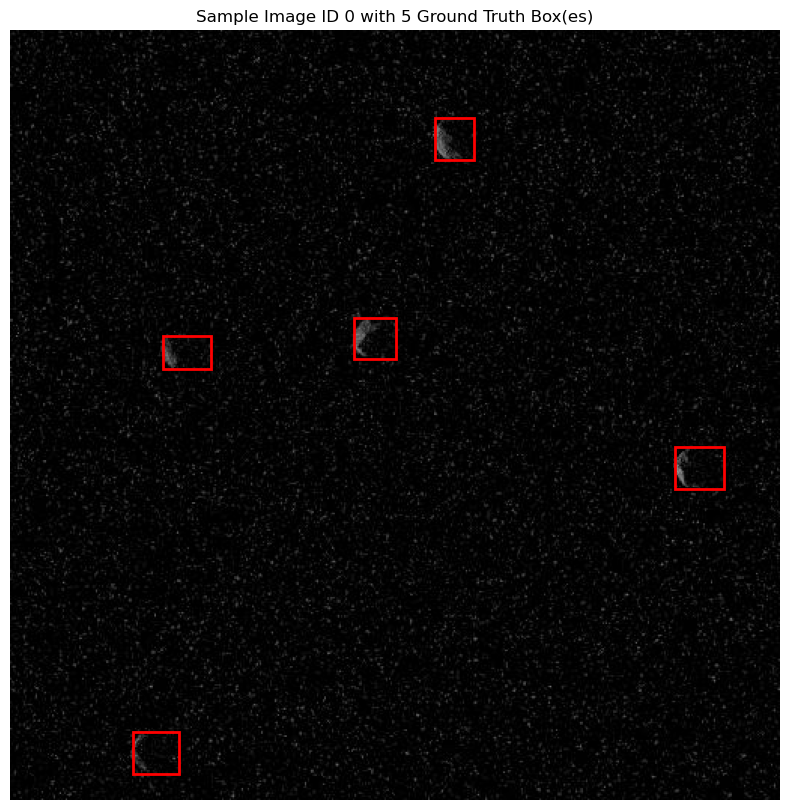

In [88]:
# Cell 7: Create Datasets and DataLoaders

dataset_train = None
dataset_val = None
data_loader_train = None
data_loader_val = None

if paths_ok: # Only proceed if paths were okay from Cell 6
    try:
        # Create Datasets
        print("\nCreating Training Dataset...")
        dataset_train = SpaceDebrisDataset(csv_file=train_csv, img_dir=train_dir, transforms=get_transform(train=True))
        print("Creating Validation Dataset...")
        dataset_val = SpaceDebrisDataset(csv_file=val_csv, img_dir=val_dir, transforms=get_transform(train=False))

        # Check dataset lengths
        print(f"\nTraining samples found: {len(dataset_train)}")
        print(f"Validation samples found: {len(dataset_val)}")

        if len(dataset_train) == 0:
            print("\n*** WARNING: Training dataset is empty. Check CSV/image paths and file matching. ***")
        if len(dataset_val) == 0:
             print("\n*** WARNING: Validation dataset is empty. Check CSV/image paths and file matching. ***")

        # Create DataLoaders only if datasets are not empty
        if len(dataset_train) > 0:
            data_loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True if DEVICE == 'cuda' else False)
        else:
             data_loader_train = None # Explicitly set to None
             
        if len(dataset_val) > 0:
            data_loader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True if DEVICE == 'cuda' else False)
        else:
             data_loader_val = None # Explicitly set to None

        print("\nDatasets and DataLoaders created (if datasets were not empty).")

        # Optional: Display a sample image and its bounding boxes
        def show_sample(dataset, index=0):
            print(f"\nAttempting to display sample at index {index} from the dataset...")
            sample = dataset[index]
            if sample is None:
                print(f"Sample at index {index} could not be loaded.")
                return
            img_tensor, target = sample
            
            # Convert tensor back to PIL image for display
            # Use v2 functional transform for display even if v1 used for training
            img_display = F.to_pil_image(img_tensor) 
            
            fig, ax = plt.subplots(1, figsize=(10, 10))
            ax.imshow(img_display)
            ax.axis('off') # Hide axes ticks

            # Check if 'boxes' key exists and has data
            num_boxes = 0
            if 'boxes' in target and len(target['boxes']) > 0:
                num_boxes = len(target['boxes'])
                # Ensure boxes are on CPU and detached for numpy conversion
                boxes_to_draw = target['boxes'].cpu().detach().numpy()
                for box in boxes_to_draw:
                    x_min, y_min, x_max, y_max = box
                    # Create a Rectangle patch
                    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
                    # Add the patch to the Axes
                    ax.add_patch(rect)
                plt.title(f"Sample Image ID {target['image_id'].item()} with {num_boxes} Ground Truth Box(es)")
            else:
                 plt.title(f"Sample Image ID {target['image_id'].item()} (No Ground Truth Boxes)")

            plt.show()

        print("\nDisplaying a sample from training set (if available):")
        # Ensure dataset_train is not empty before trying to show sample
        if dataset_train and len(dataset_train) > 0:
             show_sample(dataset_train, 0)
        else:
             print("Training dataset is empty or failed to load, cannot display sample.")

    except FileNotFoundError as e:
         print(f"\n--- ERROR Creating Dataset ---")
         print(f"File Not Found: {e}")
         print("Please ensure the 'base_data_path' in Cell 6 is correct and points to your LOCAL data directory.")
    except Exception as e:
         print(f"\n--- An unexpected error occurred while creating Datasets/DataLoaders ---")
         print(f"Error: {e}")
         traceback.print_exc() # Print detailed traceback
else:
    print("\nSkipping Dataset/DataLoader creation because path checks failed in Cell 6.")

### Cell 8: Initialize Model and Optimizer

* Calls `get_object_detection_model` to get an instance of our adapted Faster R-CNN.
* Moves the model to the selected `DEVICE` (GPU or CPU).
* Defines the optimizer (`torch.optim.SGD`) to update the model's weights during training. It's configured with the learning rate, momentum, and weight decay specified in Cell 6. Only parameters that require gradients are passed to the optimizer.

In [89]:
# Cell 8: Initialize Model, Optimizer

model = None
optimizer = None

# Only initialize if datasets/loaders were likely created successfully
if dataset_train and data_loader_train:
    try:
        # Get the model
        model = get_object_detection_model(NUM_CLASSES)

        # Move model to the right device
        model.to(DEVICE)

        # Construct an optimizer
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

        # Learning rate scheduler (optional but recommended)
        # Decreases the learning rate by 10x every 5 epochs
        # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        print("Model and optimizer initialized successfully.")
        # print(model) # Uncomment to see model structure
    except Exception as e:
        print(f"Error initializing model or optimizer: {e}")
        traceback.print_exc()
        model = None # Ensure model is None if initialization fails
        optimizer = None
else:
    print("Skipping model/optimizer initialization because dataset/dataloader creation failed or datasets were empty.")

Model and optimizer initialized successfully.


### Cell 9: Training and Validation Loop

This is the core training process:
* Iterates for the specified `NUM_EPOCHS`.
* **Training Phase (per epoch):**
    * Sets the model to `train()` mode.
    * Iterates through batches from `data_loader_train` using `tqdm` for a visual progress bar.
    * Moves images and targets to the `DEVICE`.
    * Performs a forward pass: `model(images, targets)`. In training mode, this returns a dictionary of losses.
    * Calculates the total loss by summing the individual losses.
    * Performs backpropagation (`losses.backward()`) to compute gradients.
    * Applies gradient clipping (`torch.nn.utils.clip_grad_norm_`) to prevent exploding gradients.
    * Updates model weights (`optimizer.step()`).
    * Clears gradients (`optimizer.zero_grad()`).
    * Accumulates loss and tracks processed batches.
    * Includes error handling for CUDA Out of Memory and checks for `nan`/`inf` losses.
* **Saving Model (per epoch):**
    * Saves the model's state dictionary, optimizer state, epoch number, and average loss to a `.pth` file.
* **Validation Check (per epoch - optional):**
    * Sets the model to `eval()` mode.
    * Runs inference on a few batches from `data_loader_val` without calculating gradients (`torch.no_grad()`).
* Prints epoch timing and average training loss.

In [90]:
# Cell 9: Training and Validation Loop

train_losses_epoch = []

# Check if model and dataloaders are ready
if model and optimizer and data_loader_train:
    print(f"\n--- Starting Training for {NUM_EPOCHS} Epochs ---")
    
    # Note: Calculating validation loss for detection models during training isn't standard.
    # Evaluation usually involves metrics like mAP calculated on predictions.
    # We will run evaluation separately after training.

    training_stopped_early = False
    for epoch in range(NUM_EPOCHS):
        start_time_epoch = time.time()
        # ---------- Training Phase ----------
        model.train()
        train_loss_accum = 0.0
        processed_batches = 0

        # Use tqdm for progress bar
        train_loop = tqdm(data_loader_train, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]", leave=False)
        
        for i, batch_data in enumerate(train_loop):
            # Handle potential None batch from collate_fn 
            if batch_data is None or batch_data[0] is None or batch_data[1] is None:
                continue
                
            images, targets = batch_data

            # --- Check if images are Tensors --- 
            if not all(isinstance(img, torch.Tensor) for img in images):
                 print(f"\nError: Batch {i+1} contains non-Tensor image data. Check Dataset __getitem__ and transforms.")
                 training_stopped_early = True
                 break # Stop inner loop
                 
            # Move images and targets to the DEVICE
            try:
                images = list(image.to(DEVICE) for image in images)
                targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            except AttributeError as e:
                 print(f"\nAttributeError moving data to device in batch {i+1}: {e}")
                 print("This likely means the data wasn't converted to Tensors correctly in the Dataset.")
                 training_stopped_early = True
                 break # Stop inner loop
            except Exception as e:
                 print(f"\nError moving data to device in batch {i+1}: {e}")
                 training_stopped_early = True
                 break # Stop inner loop

            # Forward pass - In train mode, model returns loss dictionary
            try:
                 # Zero gradients BEFORE forward pass
                 optimizer.zero_grad()
                 
                 loss_dict = model(images, targets)
                 
                 if not loss_dict:
                     # print(f"Warning: Empty loss dictionary returned for batch {i+1}. Skipping batch.")
                     continue
                     
                 losses = sum(loss for loss in loss_dict.values())
                 loss_value = losses.item()
                 
                 # --- Check for invalid loss values (NaN or Inf) --- 
                 if not np.isfinite(loss_value):
                     print(f"\nWarning: Non-finite loss detected ({loss_value}) at Epoch {epoch+1}, Batch {i+1}. Skipping batch.")
                     print(f"Loss Dict: {loss_dict}") # Print individual losses
                     continue # Skip this batch's backward/step
                     
                 train_loss_accum += loss_value
                 processed_batches += 1

                 # Backward pass 
                 losses.backward()
                 
                 # --- Gradient Clipping --- 
                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP_NORM)
                 
                 # Optimizer step
                 optimizer.step()
                 
                 # Update tqdm progress bar description with current average loss
                 if processed_batches > 0:
                     train_loop.set_postfix(avg_loss=f"{train_loss_accum / processed_batches:.4f}")

            except RuntimeError as e:
                 if "CUDA out of memory" in str(e):
                     print(f"\n *** CUDA Out of Memory during training batch {i+1} ***")
                     print("Try reducing BATCH_SIZE in Cell 6.")
                     torch.cuda.empty_cache()
                     training_stopped_early = True
                     break # Stop the inner loop for this epoch
                 else:
                     print(f"\nRuntime Error during training batch {i+1}: {e}")
                     continue # Skip to next batch
            except Exception as e:
                 print(f"\nGeneral Error during training batch {i+1}: {e}")
                 continue # Skip to next batch
        
        train_loop.close() # Ensure tqdm loop is closed
        
        # Check if training was stopped early within the epoch
        if training_stopped_early:
             print(f"Stopping training early in Epoch {epoch+1} due to errors.")
             break # Break outer epoch loop
             
        # End of epoch checks
        if processed_batches == 0:
             print(f"Epoch {epoch+1} completed without processing any valid batches. Check data loading and errors.")
             avg_train_loss = np.nan # Indicate no valid loss calculated
             training_stopped_early = True # Stop training if an epoch has no valid batches
             break
        else: 
            avg_train_loss = train_loss_accum / processed_batches
            train_losses_epoch.append(avg_train_loss)
            print(f"Epoch {epoch+1} Training Phase Complete. Average Loss: {avg_train_loss:.4f}")

        # Update the learning rate scheduler (if using one)
        # lr_scheduler.step()

        # ---------- Saving the Model ----------
        if np.isfinite(avg_train_loss):
            model_save_path = os.path.join(model_save_dir, f"debris_detector_epoch_{epoch+1}.pth")
            try:
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    # 'scheduler_state_dict': lr_scheduler.state_dict(), # Uncomment if using scheduler
                    'loss': avg_train_loss,
                }, model_save_path)
                print(f"Model saved to {model_save_path}")
            except Exception as e:
                 print(f"Error saving model checkpoint at epoch {epoch+1}: {e}")
        else:
             print(f"Skipping model save for epoch {epoch+1} due to non-finite average loss.")

        # ---------- Validation Check (Optional - Basic Inference) ----------
        if data_loader_val:
            model.eval()
            val_batches_processed = 0
            val_loop = tqdm(data_loader_val, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation Check]", leave=False)
            
            with torch.no_grad():
               try:
                    for batch_data_val in val_loop:
                         if batch_data_val is None or batch_data_val[0] is None or batch_data_val[1] is None:
                              continue
                              
                         images_val, _ = batch_data_val # Targets not needed for basic check
                         
                         # Check type before moving to device
                         if not all(isinstance(img, torch.Tensor) for img in images_val):
                             print("\nError: Validation batch contains non-Tensor image data.")
                             break # Stop validation check for this epoch
                             
                         images_val = list(img.to(DEVICE) for img in images_val)
                         
                         outputs = model(images_val)
                         val_batches_processed += 1
                         if val_batches_processed >= 5: # Just check a few batches
                               break 
               except RuntimeError as e:
                    if "CUDA out of memory" in str(e):
                         print("\n *** CUDA Out of Memory during validation check ***")
                    else:
                         print(f"\nRuntime Error during validation check: {e}")
               except Exception as e:
                   print(f"\nGeneral Error during validation check: {e}")
            val_loop.close() 

        epoch_time = time.time() - start_time_epoch
        print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds.")
        print("----------------------------------------------------")

    print("\n--- Training Finished (or stopped)! ---")
else:
    print("\nSkipping training loop because Model/Optimizer/DataLoader setup was not successful (check previous cell outputs for errors).")


--- Starting Training for 15 Epochs ---


Epoch 1/15 [Training]:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 1 Training Phase Complete. Average Loss: 0.3128
Model saved to ./debris_models\debris_detector_epoch_1.pth


Epoch 1/15 [Validation Check]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1 completed in 3202.38 seconds.
----------------------------------------------------


Epoch 2/15 [Training]:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 2 Training Phase Complete. Average Loss: 0.3075
Model saved to ./debris_models\debris_detector_epoch_2.pth


Epoch 2/15 [Validation Check]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2 completed in 3178.12 seconds.
----------------------------------------------------


Epoch 3/15 [Training]:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 3 Training Phase Complete. Average Loss: 0.3064
Model saved to ./debris_models\debris_detector_epoch_3.pth


Epoch 3/15 [Validation Check]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3 completed in 3206.27 seconds.
----------------------------------------------------


Epoch 4/15 [Training]:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 4 Training Phase Complete. Average Loss: 0.2985
Model saved to ./debris_models\debris_detector_epoch_4.pth


Epoch 4/15 [Validation Check]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4 completed in 3344.56 seconds.
----------------------------------------------------


Epoch 5/15 [Training]:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 5 Training Phase Complete. Average Loss: 0.2928
Model saved to ./debris_models\debris_detector_epoch_5.pth


Epoch 5/15 [Validation Check]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5 completed in 3415.18 seconds.
----------------------------------------------------


Epoch 6/15 [Training]:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 6 Training Phase Complete. Average Loss: 0.2906
Model saved to ./debris_models\debris_detector_epoch_6.pth


Epoch 6/15 [Validation Check]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6 completed in 3443.62 seconds.
----------------------------------------------------


Epoch 7/15 [Training]:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 7 Training Phase Complete. Average Loss: 0.2877
Model saved to ./debris_models\debris_detector_epoch_7.pth


Epoch 7/15 [Validation Check]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7 completed in 3524.75 seconds.
----------------------------------------------------


Epoch 8/15 [Training]:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 8 Training Phase Complete. Average Loss: 0.2865
Model saved to ./debris_models\debris_detector_epoch_8.pth


Epoch 8/15 [Validation Check]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8 completed in 2852.07 seconds.
----------------------------------------------------


Epoch 9/15 [Training]:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 9 Training Phase Complete. Average Loss: 0.2836
Model saved to ./debris_models\debris_detector_epoch_9.pth


Epoch 9/15 [Validation Check]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9 completed in 2811.07 seconds.
----------------------------------------------------


Epoch 10/15 [Training]:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 10 Training Phase Complete. Average Loss: 0.2819
Model saved to ./debris_models\debris_detector_epoch_10.pth


Epoch 10/15 [Validation Check]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10 completed in 2830.84 seconds.
----------------------------------------------------


Epoch 11/15 [Training]:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 11 Training Phase Complete. Average Loss: 0.2832
Model saved to ./debris_models\debris_detector_epoch_11.pth


Epoch 11/15 [Validation Check]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 11 completed in 2826.84 seconds.
----------------------------------------------------


Epoch 12/15 [Training]:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 12 Training Phase Complete. Average Loss: 0.2816
Model saved to ./debris_models\debris_detector_epoch_12.pth


Epoch 12/15 [Validation Check]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 12 completed in 2834.42 seconds.
----------------------------------------------------


Epoch 13/15 [Training]:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 13 Training Phase Complete. Average Loss: 0.2798
Model saved to ./debris_models\debris_detector_epoch_13.pth


Epoch 13/15 [Validation Check]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 13 completed in 2829.94 seconds.
----------------------------------------------------


Epoch 14/15 [Training]:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 14 Training Phase Complete. Average Loss: 0.2815
Model saved to ./debris_models\debris_detector_epoch_14.pth


Epoch 14/15 [Validation Check]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 14 completed in 2835.57 seconds.
----------------------------------------------------


Epoch 15/15 [Training]:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 15 Training Phase Complete. Average Loss: 0.2801
Model saved to ./debris_models\debris_detector_epoch_15.pth


Epoch 15/15 [Validation Check]:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 15 completed in 2727.78 seconds.
----------------------------------------------------

--- Training Finished (or stopped)! ---


### Cell 10: Plot Training Loss

Visualizes the average training loss recorded at the end of each epoch. This helps understand if the model was learning (loss generally decreasing) over time.


--- Plotting Training Loss ---


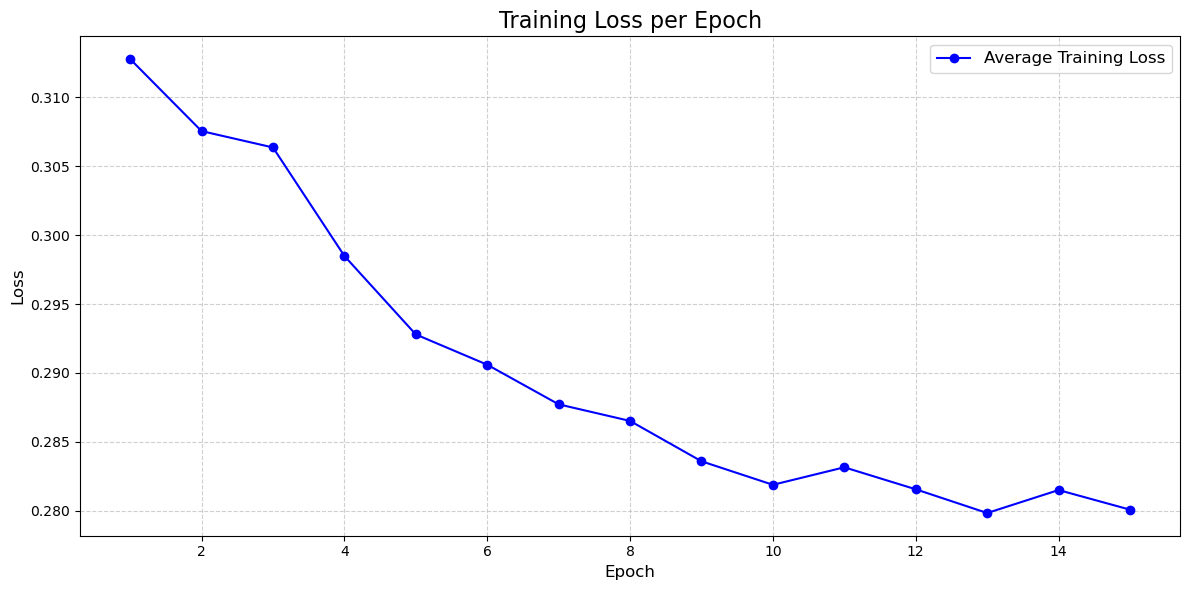

In [91]:
# Cell 10: Plot Training Loss
    
print("\n--- Plotting Training Loss ---")
# Check if train_losses_epoch exists and is not empty
if 'train_losses_epoch' in locals() and train_losses_epoch:
    # Filter out potential non-finite values if training stopped early
    valid_losses = [loss for loss in train_losses_epoch if np.isfinite(loss)]
    epochs_ran = range(1, len(valid_losses) + 1)
    
    if valid_losses:
        plt.figure(figsize=(12, 6))
        plt.plot(epochs_ran, valid_losses, marker='o', linestyle='-', color='b', label='Average Training Loss')
        plt.title('Training Loss per Epoch', fontsize=16)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        # Ensure x-ticks match the number of epochs plotted
        if len(epochs_ran) < 15: # Show all ticks if few epochs
             plt.xticks(epochs_ran)
        else: # Otherwise let matplotlib decide sensible ticks
             plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid (finite) training losses were recorded to plot.")
else:
    print("Training did not run or produced no loss data. Skipping loss plot.")

### Cell 11: Evaluation Function and Execution

* **`evaluate_model` function:**
    * Loads a saved model checkpoint.
    * Sets the model to evaluation mode (`model.eval()`).
    * Iterates through the validation dataloader (`data_loader_val`) without computing gradients (`torch.no_grad()`).
    * Performs inference on each batch.
    * Collects predictions (boxes, scores, labels) and corresponding ground truth targets.
    * Returns a dictionary containing lists of image IDs, predictions, and ground truth targets.
* **Execution:**
    * Selects the model saved after the final epoch.
    * Calls `evaluate_model` to get predictions on the validation set.
    * Prints a summary of predictions for the first few validation images, comparing predicted boxes (above a confidence threshold) with ground truth boxes.

In [92]:
# Cell 11: Evaluation Function and Execution

def evaluate_model(model_path, dataset_val, data_loader_val, device):
    """Runs inference on the validation set and returns predictions."""

    # Check if model file exists
    if not os.path.isfile(model_path):
        print(f"Error: Model file not found at {model_path}")
        return None
        
    # Check if dataloader is valid
    if not data_loader_val or len(data_loader_val) == 0:
        print("Error: Validation data loader is invalid or empty.")
        return None

    # Load the model
    try:
        print(f"\nLoading model state from: {model_path}")
        checkpoint = torch.load(model_path, map_location=device)
        model = get_object_detection_model(NUM_CLASSES) # Recreate model structure
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        model.eval() # Set model to evaluation mode
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error loading model state from {model_path}: {e}")
        return None

    all_predictions = []
    all_image_ids = []
    all_targets = [] # Store ground truth for potential comparison

    print(f"\n--- Evaluating model on Validation Set ---")
    eval_loop = tqdm(data_loader_val, desc="Evaluating", leave=False)
    with torch.no_grad():
        for i, batch_data in enumerate(eval_loop):
            if batch_data is None or batch_data[0] is None or batch_data[1] is None:
                 # print(f"Skipping potentially empty evaluation batch {i+1}/{len(data_loader_val)}")
                 continue
                 
            images, targets = batch_data

            try:
                # Check type before moving to device
                if not all(isinstance(img, torch.Tensor) for img in images):
                    print("\nError: Evaluation batch contains non-Tensor image data.")
                    break
                    
                images = list(img.to(DEVICE) for img in images)
                
                batch_image_ids = [t['image_id'].item() for t in targets]

                outputs = model(images)
                # Move predictions to CPU for storage/post-processing
                outputs_cpu = [{k: v.cpu().detach() for k, v in t.items()} for t in outputs]

                all_predictions.extend(outputs_cpu)
                all_image_ids.extend(batch_image_ids)
                 # Also store ground truth targets (on CPU)
                targets_cpu = [{k: v.cpu().detach() for k, v in t.items()} for t in targets]
                all_targets.extend(targets_cpu)
                    
            except RuntimeError as e:
                 if "CUDA out of memory" in str(e):
                     print(f"\n *** CUDA Out of Memory during evaluation batch {i+1} ***")
                     print("Evaluation may be incomplete. Try reducing BATCH_SIZE for future runs.")
                     eval_loop.close()
                     break # Stop evaluation if OOM occurs
                 else:
                     print(f"\nRuntime Error during evaluation batch {i+1}: {e}")
                     continue # Skip batch on other runtime errors
            except Exception as e:
                 print(f"\nGeneral Error during evaluation batch {i+1}: {e}")
                 continue # Skip batch on general errors

    eval_loop.close()
    print("\nEvaluation finished.")
    # Combine predictions with their image IDs
    results = {
        "image_ids": all_image_ids,
        "predictions": all_predictions,
        "ground_truth": all_targets # Include ground truth for comparison
    }
    return results


# --- Run Evaluation ---
validation_results = None
final_model_path = None

# Check if NUM_EPOCHS is defined and > 0 and training likely ran
if 'NUM_EPOCHS' in locals() and NUM_EPOCHS > 0 and 'model_save_dir' in locals() and os.path.isdir(model_save_dir):
    # Try to find the model from the last epoch where training didn't stop early
    last_successful_epoch = NUM_EPOCHS
    if 'training_stopped_early' in locals() and training_stopped_early:
        # If training stopped early, try the epoch before it potentially failed
        last_successful_epoch = len(train_losses_epoch) # Number of epochs that completed successfully
        
    potential_path = None
    if last_successful_epoch > 0:
        potential_path = os.path.join(model_save_dir, f"debris_detector_epoch_{last_successful_epoch}.pth")
        if not os.path.exists(potential_path):
             potential_path = None # Reset if the expected last successful model doesn't exist
             
    if potential_path:
         final_model_path = potential_path
         print(f"Selected model for evaluation: {os.path.basename(final_model_path)}")
    else:
        # Fallback: find the latest epoch model that exists if the above failed
        saved_models = [f for f in os.listdir(model_save_dir) if f.startswith('debris_detector_epoch_') and f.endswith('.pth')]
        if saved_models:
            try:
                saved_models.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]), reverse=True)
                final_model_path = os.path.join(model_save_dir, saved_models[0])
                print(f"Note: Model from epoch {last_successful_epoch} not found or training stopped. Using latest available: {os.path.basename(final_model_path)}")
            except Exception as e:
                print(f"Could not determine latest saved model: {e}")

    if final_model_path:
        # Ensure dataset_val and data_loader_val exist and are not None
        if 'dataset_val' in locals() and dataset_val is not None and 'data_loader_val' in locals() and data_loader_val is not None:
             validation_results = evaluate_model(final_model_path, dataset_val, data_loader_val, DEVICE)
             
             if validation_results:
                print(f"\nObtained {len(validation_results['predictions'])} prediction sets for the {len(dataset_val)} validation images.")

                # You can now process 'validation_results'
                # For example, print predictions for the first few images:
                print("\n--- Sample Validation Results (First 5 Images) ---")
                num_to_show = min(5, len(validation_results['predictions']))
                if num_to_show == 0:
                     print("No validation results to display.")
                     
                for i in range(num_to_show):
                    img_id_index = validation_results['image_ids'][i]
                    preds = validation_results['predictions'][i]
                    gt = validation_results['ground_truth'][i]

                    print(f"\n--- Image Index in Dataset: {img_id_index} ---")
                    
                    # Ground Truth Boxes
                    gt_boxes = gt.get('boxes', torch.empty((0,4)))
                    print(f"  Ground Truth Boxes ({len(gt_boxes)}):")
                    if len(gt_boxes) == 0:
                        print("    None")
                    else:
                        for box in gt_boxes.numpy():
                            print(f"    {box.round(2).tolist()}")
                        
                    # Predicted Boxes
                    pred_boxes = preds.get('boxes', torch.empty((0,4)))
                    pred_scores = preds.get('scores', torch.empty((0,)))
                    print(f"  Predicted Boxes ({len(pred_boxes)}):")
                    if len(pred_boxes) == 0:
                         print("    None")
                    else:
                        # Often useful to filter predictions by score threshold for display
                        score_threshold = 0.5
                        high_conf_indices = pred_scores > score_threshold
                        high_conf_preds = pred_boxes[high_conf_indices]
                        high_conf_scores = pred_scores[high_conf_indices]
                        print(f"    (Filtered at score > {score_threshold}): {len(high_conf_preds)}")
                        if len(high_conf_preds) == 0:
                             print("      None above threshold")
                        else:
                            for box, score in zip(high_conf_preds.numpy(), high_conf_scores.numpy()):
                                print(f"      Box [x_min, y_min, x_max, y_max]: {box.round(2).tolist()}, Score: {score:.4f}")
             else:
                 print("\nEvaluation function did not return results (check for errors above).")
        else:
             print("\nValidation dataset/dataloader not available or empty. Cannot run evaluation.")
    else:
        print(f"\nNo suitable model file found in {model_save_dir}. Cannot evaluate. Was training completed and models saved?")
else:
     print("\nSkipping evaluation as training prerequisites (epochs > 0, model save dir) are not met or training did not run.")

Selected model for evaluation: debris_detector_epoch_15.pth

Loading model state from: ./debris_models\debris_detector_epoch_15.pth


C:\Users\dhanu\AppData\Local\Temp\ipykernel_20592\1125821408.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Model loaded successfully.

--- Evaluating model on Validation Set ---


Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]


Evaluation finished.

Obtained 2000 prediction sets for the 2000 validation images.

--- Sample Validation Results (First 5 Images) ---

--- Image Index in Dataset: 0 ---
  Ground Truth Boxes (3):
    [428.0, 381.0, 457.0, 410.0]
    [100.0, 234.0, 130.0, 256.0]
    [115.0, 261.0, 147.0, 284.0]
  Predicted Boxes (3):
    (Filtered at score > 0.5): 3
      Box [x_min, y_min, x_max, y_max]: [428.1600036621094, 382.1300048828125, 455.30999755859375, 409.7300109863281], Score: 0.9999
      Box [x_min, y_min, x_max, y_max]: [114.88999938964844, 259.9599914550781, 146.2899932861328, 283.9599914550781], Score: 0.9999
      Box [x_min, y_min, x_max, y_max]: [99.79000091552734, 232.8000030517578, 129.0399932861328, 257.5899963378906], Score: 0.9999

--- Image Index in Dataset: 1 ---
  Ground Truth Boxes (3):
    [311.0, 300.0, 342.0, 331.0]
    [440.0, 54.0, 470.0, 83.0]
    [265.0, 457.0, 296.0, 486.0]
  Predicted Boxes (3):
    (Filtered at score > 0.5): 3
      Box [x_min, y_min, x_max, y_m

### Cell 12: Inference on a Single Image

* **`detect_debris_in_image` function:**
    * Loads a specified trained model checkpoint.
    * Opens and preprocesses a single input image (using validation transforms).
    * Adds a batch dimension to the image tensor.
    * Runs the model in evaluation mode (`model.eval()`) with no gradient calculation.
    * Processes the predictions: extracts boxes and scores.
    * Filters predictions based on a `score_threshold`.
    * **Changed:** Converts the *predicted* `[x_min, y_min, x_max, y_max]` boxes back to your desired output format `[xmin, xmax, ymin, ymax]`.
    * Returns the detected coordinates (in the new format) and their scores.
* **Example Usage:**
    * Selects an example image from the `test` directory.
    * Selects the trained model path (usually the one from the last epoch).
    * Calls `detect_debris_in_image` to get predictions.
    * Prints the detected coordinates (now in `[xmin, xmax, ymin, ymax]` format) and scores.
    * Visualizes the results: Displays the test image with the predicted bounding boxes drawn on it, including the confidence score next to each box.


Selected test image: C:\college\CV\COSMOS\debris-detection\test\0.jpg
Selected model for inference: ./debris_models\debris_detector_epoch_15.pth

--- Running Inference ---
Image: C:\college\CV\COSMOS\debris-detection\test\0.jpg
Model: ./debris_models\debris_detector_epoch_15.pth
Score Threshold: 0.6


C:\Users\dhanu\AppData\Local\Temp\ipykernel_20592\3797893467.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Inference complete. Found 4 boxes above threshold.

Detected 4 debris objects (score > 0.6):
  Coordinates [xmin, xmax, ymin, ymax]: [382, 408, 248, 278], Score: 0.9999
  Coordinates [xmin, xmax, ymin, ymax]: [383, 410, 439, 466], Score: 0.9999
  Coordinates [xmin, xmax, ymin, ymax]: [144, 171, 267, 296], Score: 0.9999
  Coordinates [xmin, xmax, ymin, ymax]: [34, 63, 70, 98], Score: 0.9999


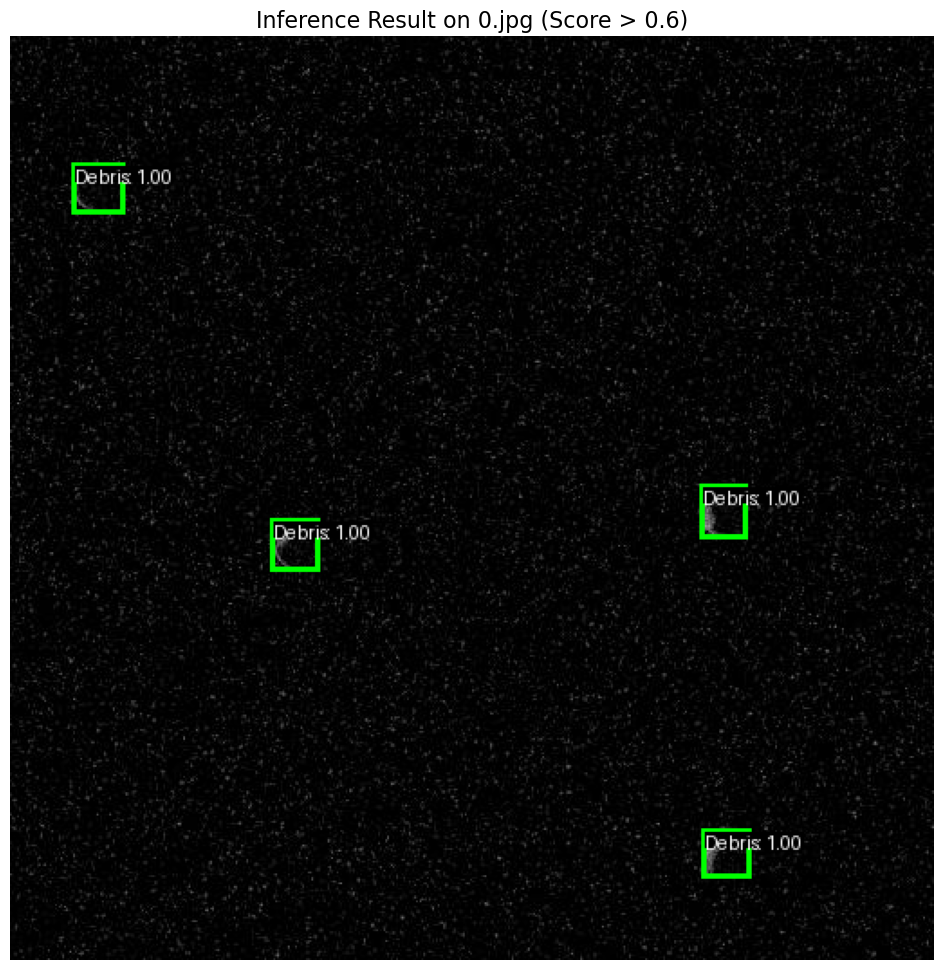

In [93]:
# Cell 12: Inference Function for Single Image

def detect_debris_in_image(image_path, model_path, device, score_threshold=0.5):
    """Loads a model and predicts debris coordinates in a single image."""
    
    print(f"\n--- Running Inference ---")
    print(f"Image: {image_path}")
    print(f"Model: {model_path}")
    print(f"Score Threshold: {score_threshold}")
    
    # Check if model and image paths exist
    if not os.path.isfile(model_path):
        print(f"Error: Model file not found at {model_path}")
        return None, None, None
    if not os.path.isfile(image_path):
        print(f"Error: Image file not found at {image_path}")
        return None, None, None

    # Load the model
    try:
        checkpoint = torch.load(model_path, map_location=device)
        model = get_object_detection_model(NUM_CLASSES)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        model.eval()
    except Exception as e:
        print(f"Error loading model state from {model_path}: {e}")
        return None, None, None

    # Load and transform the image
    try:
        img = Image.open(image_path).convert("RGB")
        original_img_for_drawing = img.copy() # Keep a copy for drawing
    except Exception as e:
        print(f"Error opening or converting image {image_path}: {e}")
        return None, None, None

    # Apply the *validation* transforms (using v1 API here as well for consistency)
    transform = get_transform(train=False)
    try:
        # Apply transform only to image
        input_tensor = transform(img) 
    except Exception as e:
         print(f"Error applying transforms to image {image_path}: {e}")
         return None, None, None

    # Add batch dimension and send to device
    input_batch = [input_tensor.to(device)]

    # Perform Inference
    try:
        with torch.no_grad():
            predictions = model(input_batch)
    except RuntimeError as e:
         if "CUDA out of memory" in str(e):
             print(f"\n *** CUDA Out of Memory during single image inference ***")
             print("Try closing other GPU-intensive applications or restarting the kernel.")
         else:
             print(f"Runtime Error during inference: {e}")
         return None, None, None
    except Exception as e:
         print(f"General Error during inference: {e}")
         return None, None, None

    # Process predictions (move to CPU, filter by score)
    pred = predictions[0] # Get prediction for the single image
    pred_boxes = pred['boxes'].cpu().numpy()
    pred_scores = pred['scores'].cpu().numpy()
    # pred_labels = pred['labels'].cpu().numpy() # Should all be 1 for debris

    # Filter by score threshold
    keep_indices = np.where(pred_scores >= score_threshold)[0]
    final_boxes_xyxy = pred_boxes[keep_indices] # Format [x_min, y_min, x_max, y_max]
    final_scores = pred_scores[keep_indices]

    # --- Convert boxes back to the requested [xmin, xmax, ymin, ymax] format --- 
    output_coords_xxyy = []
    for box in final_boxes_xyxy:
        x_min, y_min, x_max, y_max = box
        # Convert back to CSV format: [xmin, xmax, ymin, ymax]
        output_coords_xxyy.append([int(round(x_min)), int(round(x_max)), int(round(y_min)), int(round(y_max))])

    print(f"Inference complete. Found {len(output_coords_xxyy)} boxes above threshold.")
    # Return coordinates in [xmin, xmax, ymin, ymax], scores, and original PIL image
    return output_coords_xxyy, final_scores, original_img_for_drawing 

# --- Example Usage ---
test_image_example_path = None
saved_model_path_for_inference = None

# Check if test_dir is defined and exists
if 'test_dir' in locals() and os.path.isdir(test_dir):
    # List files in test_dir to find an example image
    test_files = [f for f in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if test_files:
        test_image_example_path = os.path.join(test_dir, test_files[0]) # Use the first found image
        print(f"\nSelected test image: {test_image_example_path}")
    else:
        print(f"\nWarning: No image files found in test directory: {test_dir}")
else:
    print("\nWarning: Test directory path ('test_dir') is not defined or does not exist.")
    
# Check if a model path was determined during evaluation (Cell 11)
if 'final_model_path' in locals() and final_model_path and os.path.exists(final_model_path):
    saved_model_path_for_inference = final_model_path
    print(f"Selected model for inference: {saved_model_path_for_inference}")
else:
     print("\nWarning: No valid model path found from evaluation step. Cannot run inference.")

# Proceed only if both image and model path are valid
if test_image_example_path and saved_model_path_for_inference:
    # Set a threshold for displaying boxes
    inference_threshold = 0.6 
    
    detected_coords, detected_scores, viz_img = detect_debris_in_image(
        test_image_example_path, 
        saved_model_path_for_inference, 
        DEVICE, 
        score_threshold=inference_threshold
    )

    # Check if inference was successful
    if detected_coords is not None and detected_scores is not None and viz_img is not None:
        print(f"\nDetected {len(detected_coords)} debris objects (score > {inference_threshold}):")
        if not detected_coords:
             print("  (None above threshold)")
        else:
            # Print coordinates in the requested [xmin, xmax, ymin, ymax] format
            for coord, score in zip(detected_coords, detected_scores):
                print(f"  Coordinates [xmin, xmax, ymin, ymax]: {coord}, Score: {score:.4f}")

         # Visualize the single image prediction using PIL Draw
        try:
            draw = ImageDraw.Draw(viz_img)
            # Use a default font or try to load one
            try:
                # font = ImageFont.truetype("arial.ttf", 15) # Example: Requires font file
                font = ImageFont.load_default()
            except IOError:
                font = ImageFont.load_default()
                print("Default font loaded. Consider installing a truetype font (e.g., arial.ttf) for better text rendering.")

            box_color = "lime"
            text_color = "white"
            text_bg_color = "black"

            # Draw boxes using the [xmin, xmax, ymin, ymax] format directly
            for box_xxyy, score in zip(detected_coords, detected_scores):
                x_min, x_max, y_min, y_max = box_xxyy # Extract based on [xmin, xmax, ymin, ymax] format
                # Draw rectangle: requires [(x0,y0), (x1,y1)] which is [(xmin, ymin), (xmax, ymax)]
                draw.rectangle([(x_min, y_min), (x_max, y_max)], outline=box_color, width=3)
                
                # Prepare text
                text = f"Debris: {score:.2f}"
                # Calculate text size and position
                text_bbox = draw.textbbox((0, 0), text, font=font)
                text_width = text_bbox[2] - text_bbox[0]
                text_height = text_bbox[3] - text_bbox[1]
                text_x = x_min + 2
                text_y = y_min + 2 
                # Adjust if text goes off image (simple check)
                if text_y < 0: text_y = 0 
                if text_x + text_width > viz_img.width: text_x = viz_img.width - text_width - 2
                
                # Draw text background rectangle
                draw.rectangle([(text_x, text_y), (text_x + text_width, text_y + text_height)], fill=text_bg_color)
                # Draw text
                draw.text((text_x, text_y), text, fill=text_color, font=font)

            # Display using matplotlib
            plt.figure(figsize=(12, 12))
            plt.imshow(viz_img)
            plt.title(f"Inference Result on {os.path.basename(test_image_example_path)} (Score > {inference_threshold})", fontsize=16)
            plt.axis('off')
            plt.show()
            
        except Exception as e:
             print(f"\nError visualizing inference result: {e}")
             traceback.print_exc()
    else:
         print("\nInference function did not return valid results (check for errors above).")

else:
    print(f"\nCannot run single image inference. Check conditions:")
    print(f"  Test image path is set: {test_image_example_path is not None}")
    if test_image_example_path:
         print(f"  Test image exists: {os.path.exists(test_image_example_path)}")
    print(f"  Saved model path is set: {saved_model_path_for_inference is not None}")
    if saved_model_path_for_inference:
        print(f"  Saved model exists: {os.path.exists(saved_model_path_for_inference)}")
